In [1]:
#Gerekli kütüphanelerin indirilmesi yapıldı
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tabulate import tabulate

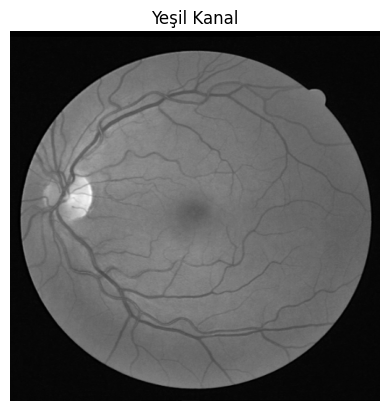

In [2]:
img = cv2.imread(r"..\sample\image.png")
green = img[:, :, 1]
plt.imshow(green , cmap='gray')
plt.title("Yeşil Kanal")
plt.axis('off')
plt.show()

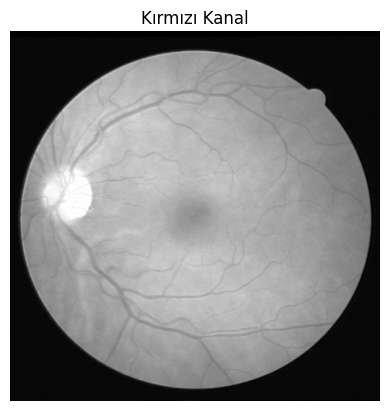

In [3]:
#Giriş görüntüsünün mask işlemleri için kırmızı kanalı alınır 
red = img[:, :, 2]
plt.imshow(red , cmap='gray')
plt.title("Kırmızı Kanal")
plt.axis('off')
plt.show()

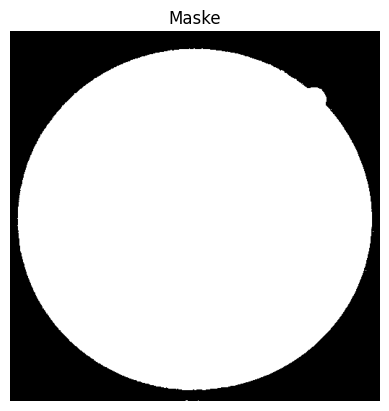

In [4]:
def create_fov_mask(red_channel):
    _, mask = cv2.threshold(red_channel, 15, 255, cv2.THRESH_BINARY)
    return mask
mask=create_fov_mask(red)
plt.imshow(mask , cmap='gray')
plt.title("Maske")
plt.axis('off')
plt.show()

Tahmin edilen gürültü seviyesi: 7.5633895237952595
Düşük gürültü seviyesi tespit edildi.


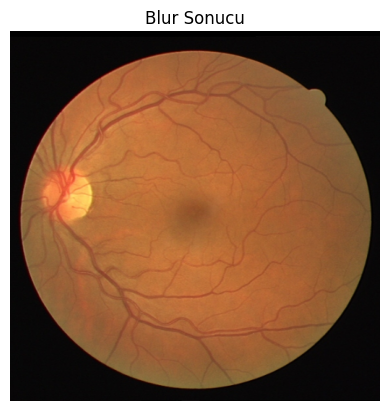

In [5]:
#Giriş görüntüsündeki gürültü oranına göre uygulanacak filtreyi seçiyor
def estimate_noise_level(img):
    """Görüntüdeki gürültü seviyesini tahmin eder."""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
        
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    noise_level = np.std(laplacian)
    return noise_level

def apply_median_filter(img, kernel_size=5):
    """Medyan filtre uygular."""
    return cv2.medianBlur(img, kernel_size)

def denoise_image(img):
    """Gürültü seviyesine göre en uygun gürültü temizleme yöntemini uygular."""
    # Gürültü seviyesini tahmin et
    noise_level = estimate_noise_level(img)
    print(f"Tahmin edilen gürültü seviyesi: {noise_level}")

    # Düşük gürültü
    if noise_level < 30:
        print("Düşük gürültü seviyesi tespit edildi.")
    else:
        print("Yüksek gürültü seviyesi tespit edildi.")
        
        # Filtre uygula ve sonucu görselleştir
        img_filtered = apply_median_filter(img)
        img = img_filtered
    
    return img

# Görüntüyü yükle
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Gürültü temizleme işlemini uygula
sonuc = denoise_image(img)
plt.imshow(sonuc )
plt.title("Blur Sonucu")
plt.axis('off')
plt.show()



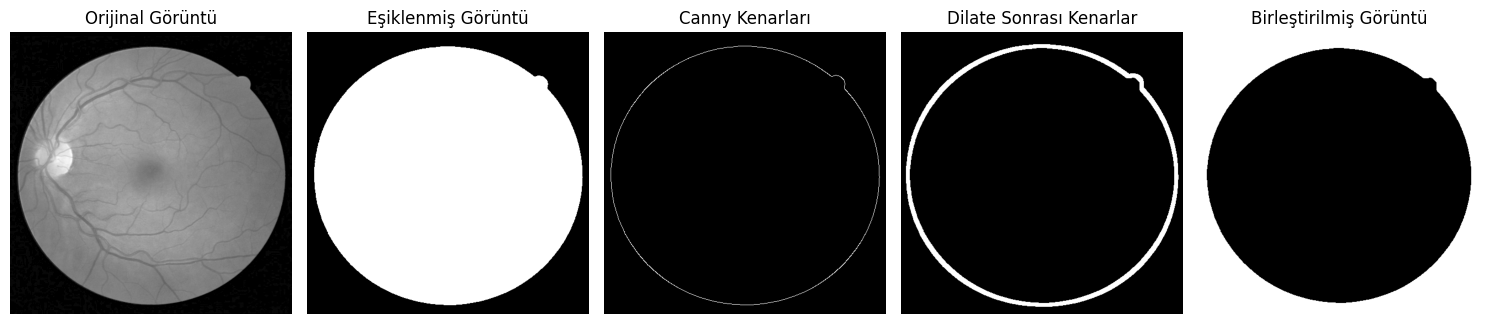

In [6]:
def get_edges(img):
    """Kenar tespiti işlemleri ve ara adımların görselleştirilmesi."""
    # İlk eşikleme
    ret, thresh1 = cv2.threshold(img, 25, 255, cv2.THRESH_BINARY)
    
    # Kenar tespiti
    edge = cv2.Canny(thresh1, 50, 150)
    
    # Dilate işlemi
    kernel = np.ones((7, 7), np.uint8)
    edge_dilated = cv2.dilate(edge, kernel, iterations=1)
    
    # Kenarlara maske ekleme
    edge_combined = cv2.add(edge_dilated, 255 - thresh1)

    # Görselleştirme
    steps = [img, thresh1, edge, edge_dilated, edge_combined]
    titles = [
        "Orijinal Görüntü",
        "Eşiklenmiş Görüntü",
        "Canny Kenarları",
        "Dilate Sonrası Kenarlar",
        "Birleştirilmiş Görüntü"
    ]
    
    plt.figure(figsize=(15, 8))
    for i, step in enumerate(steps):
        cmap = 'gray' if len(step.shape) == 2 else None
        plt.subplot(1, 5, i + 1)
        plt.imshow(step, cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return edge_combined

# Görüntüyü yükle
img = cv2.imread(r"C:\dersler\goruntuisleme\IPProje\goruntuler\images\0.png", cv2.IMREAD_GRAYSCALE)

# Kenar tespiti işlemini uygula ve görselleştir
edges = get_edges(img)


Tahmin edilen gürültü seviyesi: 7.6820104828901705
Düşük gürültü seviyesi tespit edildi.


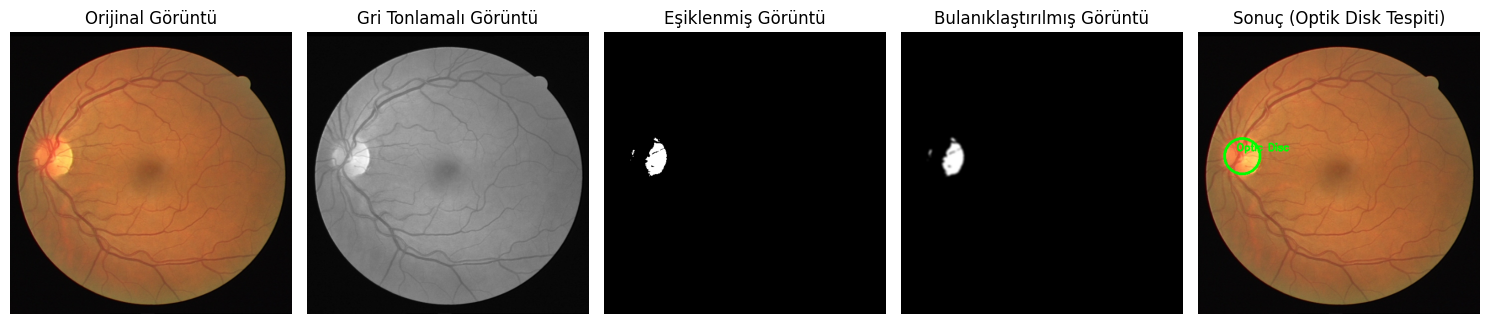

In [7]:
def process_optic_disc(image):
    """Optik diski tespit etmek için işleme ve Hough Circle algoritması."""
    gurultu=denoise_image(image)
    gray = cv2.cvtColor(gurultu, cv2.COLOR_BGR2GRAY)

    # Parlak alanları maskeleme
    _, thresholded = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
    
    # Gürültüyü azaltma
    blurred = cv2.GaussianBlur(thresholded, (7, 7), 2)
    
    # Hough Daire Tespiti
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.5,
        minDist=50,
        param1=30,
        param2=20,  # Daha hassas eşik
        minRadius=20,
        maxRadius=60
    )
    
    # Optik diski çizen fonksiyon
    output = image.copy()
    if circles is not None:
        circles = circles[0, :].astype("int")
        for i, (x, y, r) in enumerate(circles):
            if i == 0:  # Sadece birinci daireyi çizmek için
                cv2.circle(output, (x, y), r, (0, 255, 0), 3)
                cv2.putText(output, "Optic Disc", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    return gray, thresholded, blurred, output

# Görüntüyü yükle
image = cv2.imread(r"C:\dersler\goruntuisleme\IPProje\goruntuler\images\0.png")

# İşlem adımlarını uygula
gray, thresholded, blurred, output = process_optic_disc(image)

# Adımları görselleştir
steps = [image, gray, thresholded, blurred, output]
titles = [
    "Orijinal Görüntü",
    "Gri Tonlamalı Görüntü",
    "Eşiklenmiş Görüntü",
    "Bulanıklaştırılmış Görüntü",
    "Sonuç (Optik Disk Tespiti)"
]

plt.figure(figsize=(15, 10))
for i, (step, title) in enumerate(zip(steps, titles)):
    cmap = 'gray' if len(step.shape) == 2 else None
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(step, cv2.COLOR_BGR2RGB) if cmap is None else step, cmap=cmap)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


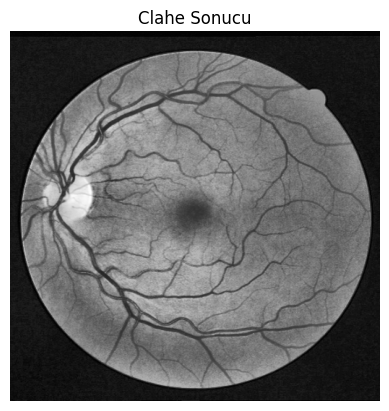

In [8]:
def make_normalizer():
    return cv2.createCLAHE(clipLimit=3.2, tileGridSize=(6, 6))
def normalize_histogram(img, normalizer):
    return normalizer.apply(img)


normalizer=make_normalizer()
clahe=normalize_histogram(green, normalizer)

plt.imshow(clahe, cmap="gray")
plt.title("Clahe Sonucu")
plt.axis('off')
plt.show()


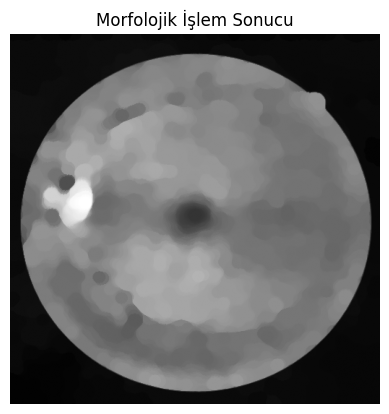

In [9]:
def get_kernels():
    kernel_sizes = [(3, 3), (5, 5), (11, 11), (17, 17)]
    return [cv2.getStructuringElement(cv2.MORPH_ELLIPSE, size) for size in kernel_sizes]

def morph_open_close(img, kernels):
    img = img.copy()
    for kernel in kernels:
        img = cv2.erode(img, kernel)
        img = cv2.dilate(img, kernel)
        img = cv2.dilate(img, kernel)
        img = cv2.erode(img, kernel)
    return img


kernels=get_kernels()
morph=morph_open_close(clahe,kernels)

plt.imshow(morph, cmap="gray")
plt.title("Morfolojik İşlem Sonucu")
plt.axis('off')
plt.show()


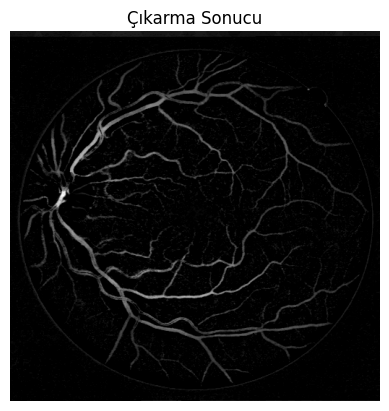

In [10]:
def subtract(img1, img2):
    return cv2.subtract(img1, img2)

sub =subtract(morph,clahe)
plt.imshow(sub, cmap="gray")
plt.title("Çıkarma Sonucu")
plt.axis('off')
plt.show()


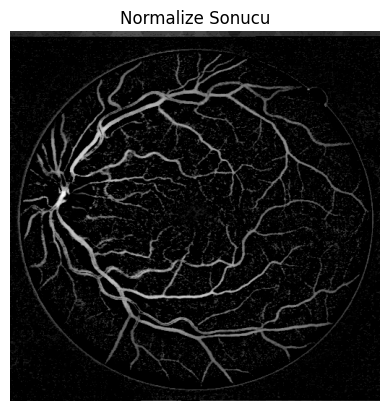

In [11]:
def normalize_histogram(img, normalizer):
    return normalizer.apply(img)

hist = normalize_histogram(sub,normalizer)
plt.imshow(hist, cmap="gray")
plt.title("Normalize Sonucu")
plt.axis('off')
plt.show()

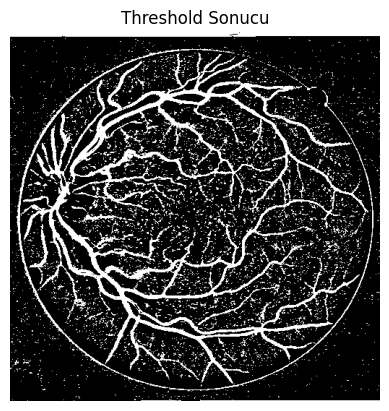

In [12]:
def thresh(img):
    return cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]


th1=thresh(hist)
plt.imshow(th1,cmap="gray")
plt.title("Threshold Sonucu")
plt.axis('off')
plt.show()

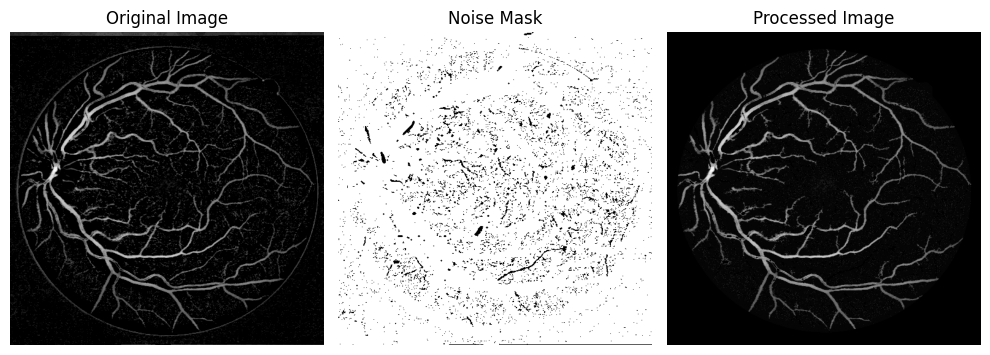

In [13]:
def create_mask(img):
    return np.ones(img.shape[:2], dtype="uint8") * 255

def make_contours(img, mask):
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= 150:
            cv2.drawContours(mask, [contour], -1, 0, -1)

def make_bitwise(img, noise_mask):
    return cv2.bitwise_and(img, img, mask=noise_mask)

# Assuming th1, tekrar, and kenarlar are already defined as your thresholded image, original image, and edge-detected image
noisemask = create_mask(th1)
make_contour = make_contours(th1, noisemask)
masked = make_bitwise(hist, noisemask)
masked1 = cv2.subtract(masked, edges)

# Visualizing the result
plt.figure(figsize=(10, 8))

# Display the original image, mask, and processed image
plt.subplot(1, 3, 1)
plt.imshow(hist, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisemask, cmap='gray')
plt.title("Noise Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked1, cmap='gray')
plt.title("Processed Image")
plt.axis('off')

plt.tight_layout()
plt.show()


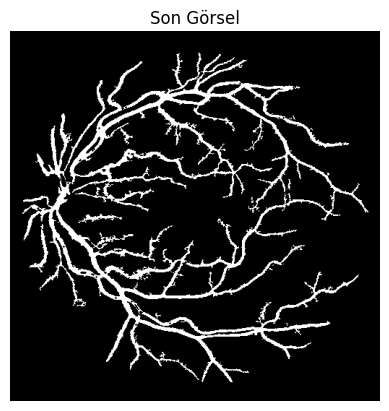

In [14]:
finalresult=thresh(masked1)
plt.imshow(finalresult, cmap="gray")
plt.title("Son Görsel")
plt.axis('off')
plt.show()

0.5986410935451943


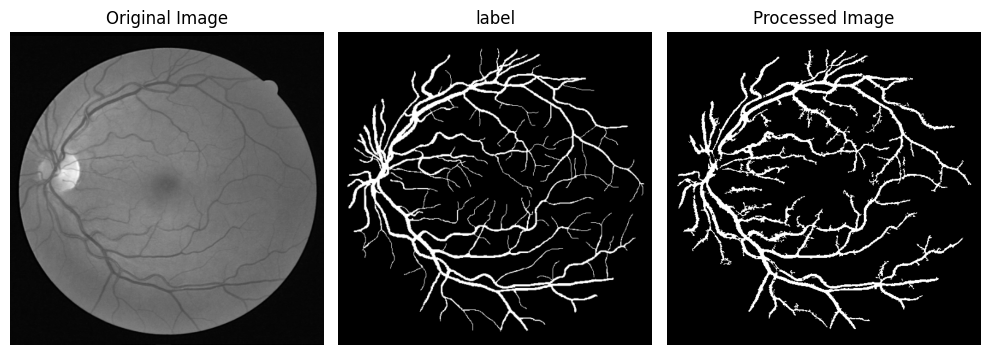

In [16]:
def calculate_iou(pred, label):
    intersection = np.logical_and(pred, label).sum()
    union = np.logical_or(pred, label).sum()
    return intersection / union if union != 0 else 0

label= cv2.imread(r"..\sample\label.png")
label=label[:, :, 1]
print(calculate_iou(finalresult, label))

# Visualizing the result
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.imshow(green, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(label, cmap='gray')
plt.title("label")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(finalresult, cmap='gray')
plt.title("Processed Image")
plt.axis('off')

plt.tight_layout()
plt.show()